# Week 2 Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

## Tuning Functions

In [2]:
def gridSearch(X, Y, repeat, n_splits, scorer, mod, hyperparameters,  n_jobs=None, stratify=True):
    # GridSearch Wrapper Fucntion
    print("Number of repeats run is: " + str(repeat))
    dfL = []
    for i in range(0,repeat):
        if stratify==True:
            cv = StratifiedKFold(n_splits=n_splits, random_state=i, shuffle=True)
        else:
            cv = KFold(n_splits=n_splits, random_state=i, shuffle=True)
        boosted_grid = GridSearchCV(mod, hyperparameters, scoring=scorer, cv=cv, verbose=0, refit=True, error_score=np.nan, return_train_score=True, n_jobs=n_jobs) #n_jobs=n_jobs,
        grid_fit = boosted_grid.fit(X, Y)
        DF = pd.DataFrame(grid_fit.cv_results_)
        DF['Iteration'] = i
        dfL.append(DF)
    DFall = pd.concat(dfL)
    return DFall


def OverSampler(parentDIR,df, xfilename, yfilename):
    # Oversample small class to balanced data
    os.chdir(parentDIR)
    df = df.dropna()
    X = df.iloc[:,4:].copy()
    X['TimeGroup'] = df.TimeGroup.copy()
    X = pd.get_dummies(X)
    Y = df.Status.copy()

    ros = RandomOverSampler(random_state=0)
    Xoversampled, Yoversampled = ros.fit_resample(X, Y)

    if not os.path.isdir('OverSampled'):
        os.makedirs('OverSampled')
    os.chdir('OverSampled')

    Xoversampled.to_csv(xfilename, sep='\t')
    Yoversampled.to_csv(yfilename, sep='\t')
    return Xoversampled, Yoversampled

## Data Loading

In [3]:
parentdir = os.getcwd()

X = pd.read_csv('W2_predictor.txt', sep='\t', index_col=0)
Y = pd.read_csv('W2_response.txt', sep='\t', index_col=0).squeeze()

## Model Tuning

In [4]:
os.chdir(parentdir)
if not os.path.isdir('Results'):
    os.makedirs('Results')
os.chdir('Results')
RAND=np.random.RandomState(4)

param_space = {'C':np.logspace(-5,2,4),
                'l1_ratio':[float(x) for x in np.linspace(0.1,0.9,4)]}
enet = LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter=int(1e6))

Enet = gridSearch(X=X, Y=Y, repeat=200, n_splits=10, scorer='roc_auc', mod=enet, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
Enet.to_csv('W2_EnetBurkPx_GridSearch.txt', sep='\t')
Enet['params2'] = Enet['params'].astype(str)
print('Finished Enet')


param_space = {'C':np.logspace(-5,3,10),
                'penalty':['l1', 'l2']}
lr = LogisticRegression( solver = 'saga', max_iter=int(1e6))

LR = gridSearch(X=X, Y=Y, repeat=200, n_splits=10, scorer='roc_auc', mod=lr, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
LR.to_csv('W2_LRBurkPx_GridSearch.txt', sep='\t')
LR['params2'] = LR['params'].astype(str)
print('Finished LR')


param_space = {'learning_rate': np.logspace(-3, -1,4),
                'n_estimators': [25, 50],
                'subsample': np.linspace(0.2,0.9,3),
                'colsample_bytree':np.linspace(0.05, 0.5, 3),
                'max_depth':[int(x) for x in np.linspace(3,20,3)]}

xgb =  XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=RAND) #, scale_pos_weight=len(Y==0)/len(Y==1) BinaryFocalLoss

LR = gridSearch(X=X, Y=Y, repeat=200, n_splits=10, scorer='roc_auc', mod=xgb, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
LR.to_csv('W2_XGBBurkPx_GridSearch.txt', sep='\t')
LR['params2'] = LR['params'].astype(str)

Number of repeats run is: 200
Finished Enet
Number of repeats run is: 200
Finished LR
Number of repeats run is: 200


## Preliminary Figure Analysis
### Enet

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, "{'C': 1e-05, 'l1_ratio': 0.1}"),
  Text(1, 0, "{'C': 1e-05, 'l1_ratio': 0.3666666666666667}"),
  Text(2, 0, "{'C': 1e-05, 'l1_ratio': 0.6333333333333333}"),
  Text(3, 0, "{'C': 1e-05, 'l1_ratio': 0.9}"),
  Text(4, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.1}"),
  Text(5, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.3666666666666667}"),
  Text(6, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.6333333333333333}"),
  Text(7, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.9}"),
  Text(8, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.1}"),
  Text(9, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.3666666666666667}"),
  Text(10, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.6333333333333333}"),
  Text(11, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.9}"),
  Text(12, 0, "{'C': 100.0, 'l1_ratio': 0.1}"),
  Text(13, 0, "{'C': 100.0, 'l1_ratio': 0.3666666666666667}"),
  Text(14, 0, "{'C': 100.0, 'l1_ratio': 0.6

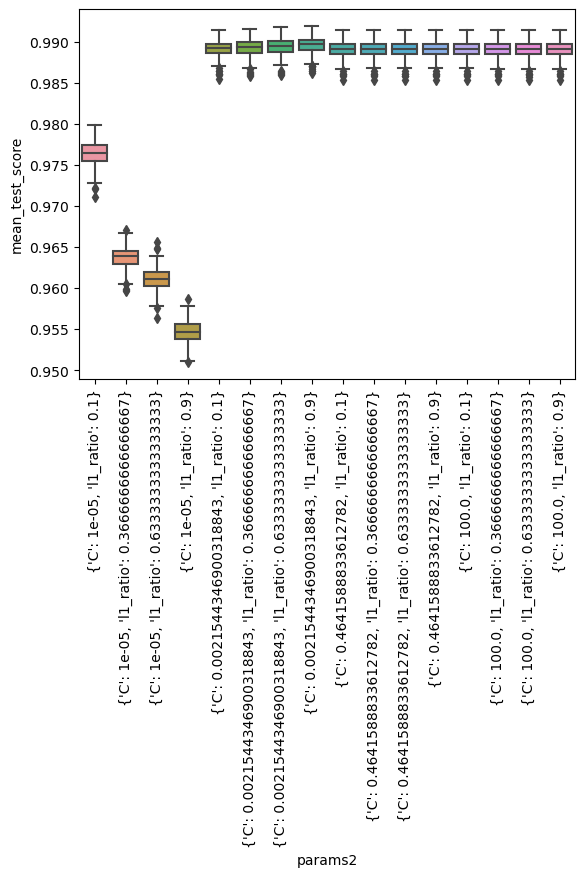

In [5]:
LR = pd.read_csv('W2_EnetBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

### Penalized Logit

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, "{'C': 1e-05, 'penalty': 'l1'}"),
  Text(1, 0, "{'C': 1e-05, 'penalty': 'l2'}"),
  Text(2, 0, "{'C': 7.742636826811278e-05, 'penalty': 'l1'}"),
  Text(3, 0, "{'C': 7.742636826811278e-05, 'penalty': 'l2'}"),
  Text(4, 0, "{'C': 0.0005994842503189409, 'penalty': 'l1'}"),
  Text(5, 0, "{'C': 0.0005994842503189409, 'penalty': 'l2'}"),
  Text(6, 0, "{'C': 0.004641588833612777, 'penalty': 'l1'}"),
  Text(7, 0, "{'C': 0.004641588833612777, 'penalty': 'l2'}"),
  Text(8, 0, "{'C': 0.03593813663804626, 'penalty': 'l1'}"),
  Text(9, 0, "{'C': 0.03593813663804626, 'penalty': 'l2'}"),
  Text(10, 0, "{'C': 0.2782559402207126, 'penalty': 'l1'}"),
  Text(11, 0, "{'C': 0.2782559402207126, 'penalty': 'l2'}"),
  Text(12, 0, "{'C': 2.154434690031882, 'penalty': 'l1'}"),
  Text(13, 0, "{'C': 2.154434690031882, 'penalty': 'l2'}"),
  Text(14, 0, "{'C': 16.681005372000556, 'penalty': 'l1'}"),
  Text(

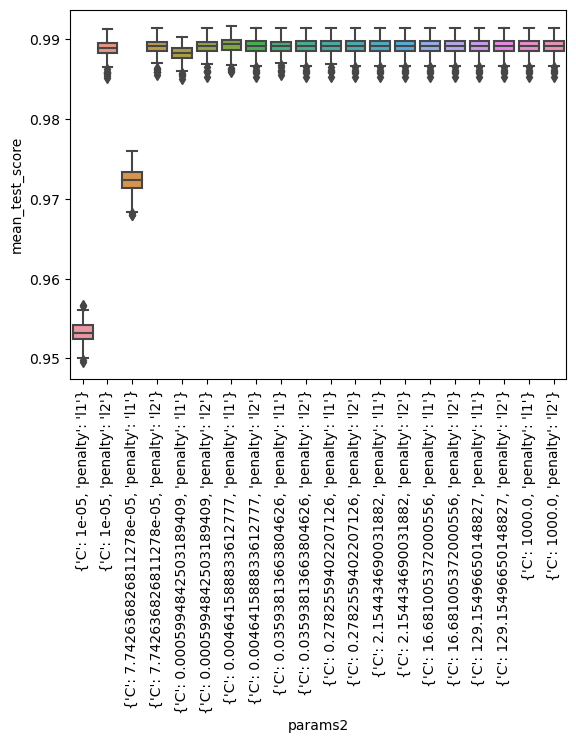

In [6]:
LR = pd.read_csv('W2_LRBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

### XGB

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

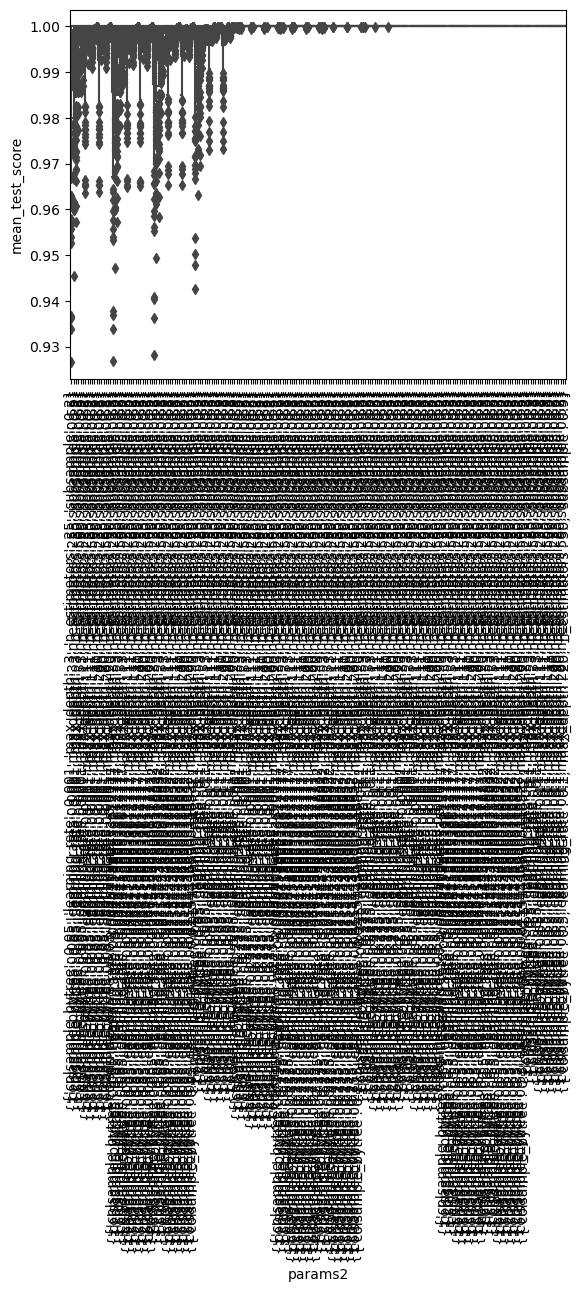

In [7]:
LR = pd.read_csv('W2_XGBBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

## Overall Model Comparison

/var/folders/20/192vzyys2_b6v3q3tlh1tmd40000gn/T/ipykernel_2485/3041629679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W1Enet['Model']  = 'ElasticNet'
/var/folders/20/192vzyys2_b6v3q3tlh1tmd40000gn/T/ipykernel_2485/3041629679.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W1XGB['Model'] = 'XGBoost'


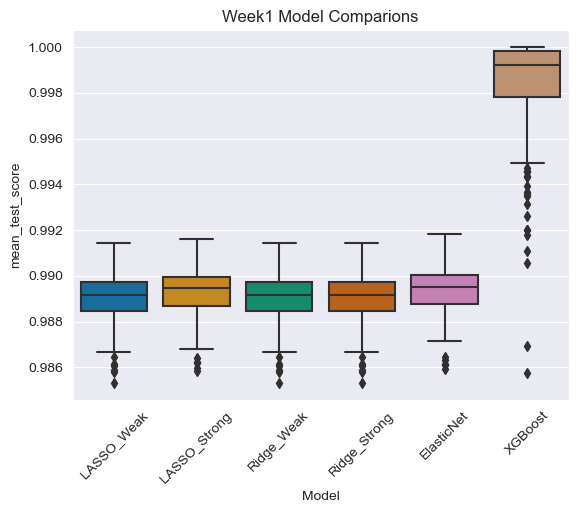

In [8]:
os.chdir(parentdir)
os.chdir('Results')

LR = pd.read_csv('W2_EnetBurkPx_GridSearch.txt', sep='\t', index_col=0)
W1Enet = LR.loc[LR['params'] =="{'C': 0.0021544346900318843, 'l1_ratio': 0.6333333333333333}"]
W1Enet['Model']  = 'ElasticNet'

LR = pd.read_csv('W2_LRBurkPx_GridSearch.txt', sep='\t', index_col=0)
W1LASSOWeak=LR.loc[LR['params']== "{'C': 1000.0, 'penalty': 'l1'}"].copy()
W1LASSOWeak['Model'] = 'LASSO_Weak'

W1LASSOstrong=LR.loc[LR['params']== "{'C': 0.004641588833612777, 'penalty': 'l1'}"].copy()
W1LASSOstrong['Model'] = 'LASSO_Strong'

W1RIDGEWeak=LR.loc[LR['params']== "{'C': 1000.0, 'penalty': 'l2'}"].copy()
W1RIDGEWeak['Model'] = 'Ridge_Weak'

W1RIDGEstrong=LR.loc[LR['params']== "{'C': 0.004641588833612777, 'penalty': 'l2'}"].copy()
W1RIDGEstrong['Model'] = 'Ridge_Strong'


LR = pd.read_csv('W2_XGBBurkPx_GridSearch.txt', sep='\t', index_col=0)
W1XGB = LR.loc[LR['params']=="{'colsample_bytree': 0.05, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.55}"]
W1XGB['Model'] = 'XGBoost'
BEST = pd.concat([W1LASSOWeak, W1LASSOstrong, W1RIDGEWeak, W1RIDGEstrong, W1Enet, W1XGB])

BEST['params2'] = BEST['params'].astype(str)

sns.set_style('darkgrid')
sns.set_palette('colorblind')
fig, ax = plt.subplots()
sns.boxplot(data=BEST, y= 'mean_test_score', x='Model', hue=None, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Week1 Model Comparions')

fig.savefig('Week2_Model_Comparison_Oversampled_rocAUC.png', bbox_inches='tight', dpi=300)

## Analyzing Validation Set
### Enet

In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
os.chdir('../../ValidationSet')

df = pd.read_csv('ValidationSet.txt', sep='\t', index_col=0)
Week2 = df.loc[(df['TimeGroup']=='Week2')|(df['TimeGroup']=='Healthy')]

yVAL = Week2.Status.copy()
yVAL.replace('Melioid', 1, inplace=True)
yVAL.replace('Negative', 0, inplace=True)

XVAL = Week2.iloc[:,4:].copy()
XVAL = pd.get_dummies(XVAL)

ros = RandomUnderSampler(random_state=0)
Xunder, Yunder = ros.fit_resample(XVAL, yVAL)


enet = LogisticRegression(penalty = 'elasticnet', C=0.0021544346900318843, l1_ratio=0.6333333333333333, solver = 'saga', max_iter=int(1e6)).fit(Xunder, Yunder)
# roc_auc_score(y, clf.predict_proba(X)[:, 1])
roc_auc_score(Yunder, enet.predict_proba(Xunder)[:, 1])
# roc_auc_score(yVAL, enet.decision_function(XVAL))

1.0